<a href="https://colab.research.google.com/github/amengemeda/ISproject-2/blob/main/MT5_finetuning_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Load libraries and data**

In [1]:
!pip install klib sentencepiece transformers 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 6.3 MB/s 
     |████████████████████████████████| 5.5 MB 84.7 MB/s 
     |████████████████████████████████| 133 kB 72.9 MB/s 
     |████████████████████████████████| 7.6 MB 77.0 MB/s 
     |████████████████████████████████| 163 kB 94.6 MB/s 
  Attempting uninstall: Jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import klib
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import optim
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from transformers import T5Tokenizer, MT5ForConditionalGeneration
from tqdm.notebook import tqdm as tqdm_notebook_
from scipy.signal import savgol_filter
import random
import copy
import os

In [3]:
#mount the drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
class Model:
  
  # def _init_(self):
  #   drive.mount('/content/drive')

  #fetch the dataset from the drive
  def load_data(self):
    #load data
    self.labels = pd.read_csv('/content/drive/MyDrive/Machine Learning/Data/Amharic-Hate-Speech-Dataset/Labels.txt',header=None)
    self.posts = pd.read_csv('/content/drive/MyDrive/Machine Learning/Data/Amharic-Hate-Speech-Dataset/Posts.txt',header=None)
  
  #merge the individual columns of the dataset into a single dataset
  def preprocess_data(self):
    self.labels.columns = ["target_text"]
    self.posts.columns = ["input_text"]
    self.labels = self.labels.replace(['Free', 'Free ','Hate'],['Free','Free','Hate'])
    self.data = pd.concat([self.posts,self.labels], axis=1)
  
  def visualize_data(self):
    return self.data.head(10)

  def dataset_balance(self):
    return self.data['target_text'].hist(bins=len(self.data.columns))

    # Splitting the dataset into train, validation, and test
  def split_dataset(self):
    self.train_df, test_val_df = train_test_split(self.data, test_size=0.30, random_state=42)
    self.test_df, self.eval_df = train_test_split(test_val_df, test_size=0.33, random_state=42)
    print('Training dataset shape: ', self.train_df.shape)
    print('Validation dataset shape: ', self.eval_df.shape)
    print('Testing dataset shape: ', self.test_df.shape)

  # Initialize model and Loading the tokenizer and the model
  def load_model(self,model_repo,model_path):
    self.model_repo = model_repo
    self.model_path = model_path
    if not os.path.exists(model_path):
      os.mkdir(model_path)
    self.tokenizer = AutoTokenizer.from_pretrained(model_repo)
    model = MT5ForConditionalGeneration.from_pretrained(model_repo)
    self.model = model.cuda()

  def encode_entries(self,column,plt_name,x_label):
    token_len = []
    for row in self.data[column]:
      input_ids = self.tokenizer.encode(row, return_tensors='pt').cuda()
      token_len.append(len(input_ids[0]))

    token_len.sort(reverse=True)

    plt.figure(figsize=(6, 4),tight_layout=True, dpi=80)
    plt.hist(token_len)
    plt.xlabel(x_label)
    plt.ylabel('frequency')
    plt.savefig(plt_name)
  
  def initialize_seq_len(self, max_inp_seq_len, max_tar_seq_len):
    self.max_inp_seq_len = max_inp_seq_len
    self.max_tar_seq_len = max_tar_seq_len

  # resize the input token embeddings of the model if len(tokenizer) != model.config.vocab_size
  def resize_token_emb(self):
    self.model.resize_token_embeddings(len(self.tokenizer))

  # function to encode a given string and return token ids
  def encode_str(self, text, tokenizer,max_seq_len):  
    """ Tokenize, pad to max length and encode to ids 
        Returns tensor with token ids """
    input_ids = tokenizer.encode(
        text=text,
        return_tensors = 'pt',
        padding = 'max_length',
        truncation = True,
        max_length = max_seq_len)

    return input_ids[0] 

  # function to encode a given row from the dataset, containing 'input_text' and 'target_text'
  # returns input and target token ids
  def encode_row(self, row, tokenizer, seq_inp_len, seq_tar_len):
    """Encode input and tagret texts from single row"""
    """Returns input and output token ids"""
    input_text = row['input_text']
    target_text = row['target_text']

    if input_text is None or target_text is None:
      return None

    input_token_ids = self.encode_str(
        input_text, tokenizer, seq_inp_len)
    
    target_token_ids = self.encode_str(
        target_text, tokenizer, seq_tar_len)

    return input_token_ids, target_token_ids
  
  # function to encode a single batch and return input and output batch token ids
  def encode_batch(self, batch, tokenizer):
    """Encode a single batch"""
    """Returns input and output batch token ids"""
    inputs = []
    targets = []
    for index, row in batch.iterrows():
      #gets input and output tocken ids
      formatted_data = self.encode_row(row, tokenizer, self.max_inp_seq_len, self.max_tar_seq_len)
  #    print("i/o tocken ids:",formatted_data)    
      if formatted_data is None:
        continue
      
      input_ids, target_ids = formatted_data
      #unsqueeze(input, dim) returns a new tensor with a dimension of size one inserted at the specified position
      inputs.append(input_ids.unsqueeze(0))
      targets.append(target_ids.unsqueeze(0))
  #  print('squeezed tocken ids:',inputs)
    
  #Concatenate the given sequence of seq tensors in the given dimension    
    batch_input_ids = torch.cat(inputs).cuda()
    batch_target_ids = torch.cat(targets).cuda()

    return batch_input_ids, batch_target_ids

  # function to create a generator object to generate batches of data

  def data_generator(self, dataset, tokenizer, batch_size=32):
    """"generates batches"""
    #shuffle the data
    dataset=dataset.sample(frac=1).reset_index(drop=True)

    for i in range(0, len(dataset), batch_size):
      raw_batch = dataset[i:i+batch_size]
      yield self.encode_batch(raw_batch, tokenizer)

  
  # defining the parameters required for fine-tuning
  def set_training_parameters(self, n_epochs, train_batch_size, eval_batch_size, lr):
    self.n_epochs = n_epochs
    self.train_batch_size = train_batch_size
    self.eval_batch_size = eval_batch_size
    self.lr = lr 

    self.n_batches = int(np.ceil(len(self.train_df) / train_batch_size)) 
    self.total_steps = n_epochs * self.n_batches 
    self.n_warmup_steps = int(self.total_steps * 0.01) 

    val_freq = np.ceil(10*eval_batch_size*self.n_batches/len(self.eval_df))*2
    while val_freq%5 != 0:
      val_freq += 1
    val_freq = round(val_freq)

    self.print_freq = val_freq
    self.val_freq = val_freq

    checkpoint_freq = np.ceil(self.n_batches/10)
    while checkpoint_freq%100 != 0:
      checkpoint_freq -= 1
    self.checkpoint_freq = round(checkpoint_freq)

  # function to evaluate the model during training at a given frequency

  def eval_model(self, val_generator_object, max_iters=6):
    """evaluate the model on small validation data"""
    
    eval_losses = []
    for i, (input_batch, label_batch) in enumerate(val_generator_object):
      if i >= max_iters:
        break

      model_out = self.model.forward(
          input_ids = input_batch,
          labels = label_batch)
      eval_losses.append(model_out.loss.item()) 

    return np.mean(eval_losses)

  def fine_tune_model(self, optimizer, scheduler):
    # fine-tuning the model and save the checkpoints
    losses = []
    val_losses = []
    for epoch_idx in range(self.n_epochs):
      # generate batch data
      train_generator = self.data_generator(self.train_df, self.tokenizer, self.train_batch_size)
      val_generator = self.data_generator(self.eval_df, self.tokenizer, self.eval_batch_size)
                    
      for batch_idx, (input_batch, label_batch) in tqdm_notebook_(enumerate(train_generator), total=self.n_batches):
        #zeroes all the gradients before the calculation
        optimizer.zero_grad()

        # Forward pass
        model_out = self.model.forward(input_ids = input_batch, labels = label_batch)

        # Calculate loss
        loss = model_out.loss
        # loss.item() gets the scalar value held in the loss.  item() turns a Tensor into a Python number
        losses.append(loss.item())
        #backpropagation - computing the gradient of the loss function with respect to each weight
        loss.backward()
        # updating weights to minimize loss
        optimizer.step()
        #You call scheduler.step() every batch, right after optimizer.step(), to update the learning rate.
        scheduler.step()

        # Print training update info
        # At an interval of print_freq or val_freq
        if (batch_idx + 1) % self.print_freq == 0:
          #average loss for the last 'print_freq' batches
          avg_loss = np.mean(losses[-self.print_freq:])
          val_loss = self.eval_model(val_generator)
          print('Epoch: {} | Step: {} | Avg. train loss: {:.3f} | Avg. val loss: {:.3f} | lr: {}'.format(
              epoch_idx+1, batch_idx+1, avg_loss, val_loss, scheduler.get_last_lr()[0]))
          val_losses.append(val_loss)
          

        # save the model for every 'checkpoint_freq' steps
        # if (batch_idx + 1) % checkpoint_freq == 0:      
        #   torch.save(model.state_dict(), os.path.join(model_path+ 'Step-{}_checkpoint_lang_pred.pt'.format(batch_idx + 1)))
    self.val_losses = val_losses
    self.losses = losses
    torch.save(self.model.state_dict(), os.path.join(self.model_path+ 'Step-{}_checkpoint_lang_pred.pt'.format(batch_idx + 1)))

  def visualize_loss(self, train_loss_, val_loss_):
    # visualizing the training and validation losses

    # Actual training loss with low opacity
    fig = plt.figure(figsize=(10, 5), dpi=80)
    plt.plot(train_loss_, alpha=0.15, color='orange')

    # smoothening the training loss
    # window size is chosen depending upon the amount of smoothening required
    window = 11
    order = 1
    y_ = savgol_filter(train_loss_['0'], window, order)
    plt.plot(y_, color='orange', label='Training loss (smoothened)')

    # Validation loss
    val_loss_df = copy.deepcopy(val_loss_) 
    val_loss_df.index = (val_loss_.index+1)*self.val_freq
    plt.plot(val_loss_df, label='Validation loss')

    plt.legend(loc="upper right")
    plt.xlabel('Steps')

    # save the plot if needed
    fig.savefig('/content/drive/MyDrive/Machine Learning/Loss/Loss_Plot.png', dpi=fig.dpi)


  # function to test the model on 'max_iter' examples 
  def test_model(self, test_df, wrong_prediction, max_iter):

    max_test_iters = max_iter
    correct_predictions = 0

    for _ in range(max_test_iters):
      num = random.randint(0,len(test_df['input_text'])-1)
      test = test_df.iloc[num]

      input_ids = self.encode_str(text = test['input_text'], tokenizer = self.tokenizer, max_seq_len=40)
      input_ids = input_ids.unsqueeze(0).cuda()

      #print('Truncated input text:', tokenizer.convert_tokens_to_string(
      #  tokenizer.convert_ids_to_tokens(input_ids[0])))

      output_tokens = self.model.generate(input_ids, num_beams=10, num_return_sequences=1, length_penalty = 1, no_repeat_ngram_size=2)
      # print(output_tokens)
      for token_set in output_tokens:
        prediction = self.tokenizer.decode(token_set,skip_special_tokens=True)
        if prediction == test['target_text']:
          correct_predictions += 1
        else:
          wrong_prediction.append([test['input_text'], test['target_text'], prediction])

    return correct_predictions/max_test_iters, wrong_prediction


In [5]:
#instantiate the model
model = Model()

In [6]:
#load dataset
model.load_data()

In [7]:
#preprocess the dataset
model.preprocess_data()

In [8]:
#snippet of the dataset
model.visualize_data()

,input_text,target_text
0,አስቀድሜ ጥያቄዬ በጨዋነት በውስጥ መስመር እንዲደርስዎ አድርጌ ፍትህን ለ...,Free
1,እነዚህን ወሳኝ ጉዳዮችን የሚያስፈፅም አካል እንዲቋቋምና ክትትል እንዲደ...,Free
2,የአማራ ህዝብ በአእምሮ ክንፉ ያልበረረበት ጥበብና ፍልስፍና ያልከፈተው የ...,Free
3,ከአማራ ህዝብ የሀገሪቱ ዘርፈ ብዙ እውቀት መንጭቶ የሞላበትከሙላቱም በመል...,Free
4,ዛሬ በየትኛውም መለኪያ ይሁን መመዘኛ ኢትዮጵያዊነት የሚንፀባረቀው በአማራ...,Hate
5,በአማራ ህዝብ ግን ደም የገበረባትአጥንት የከሰከሰባት ሰንደቅአላማ ናትና ...,Free
6,የኢትዮጵያ ብሄራዊ ቡድን በመቀሌ እስታዲየም ሲጫወት የገቡት ደጋፊዎች በፍ...,Free
7,ዛሬም የአርሰናሉን ፔፔን የቶተንሀሙን ሰርጅ አውሪር ይዞ የገባው ኮትዲሾዋ...,Free
8,ስማ ለምን ኡነተኛ ታሪክ አታወራም ለምንስ የሰው ታሪክ ትሰርቃላቹ የኢትዮ...,Hate
9,ሀገራዊ ወግ ያለው ለሁሉ የሆነ አስገድዶ ሳይሆን በፍቅርና በልዩ ሰዋዊ አ...,Free


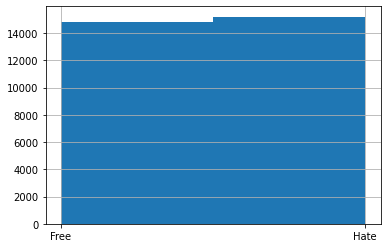

In [9]:
#Visualizing the distribution of target text in the dataset
#This is helpful to check if the dataset is balanced
model.dataset_balance()

In [10]:
#Splitting the dataset into train, validation, and test
model.split_dataset()

Training dataset shape:  (21000, 2)
Validation dataset shape:  (2970, 2)
Testing dataset shape:  (6030, 2)


In [11]:
# Initializing and Loading the model and the tokenizer
model.load_model("google/mt5-large",'/content/drive/MyDrive/Machine Learning/fine-tuned_mt5/')

Downloading:   0%|          | 0.00/376 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/642 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/convert_slow_tokenizer.py:447: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"


Downloading:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

In [12]:
# resize the input token embeddings of the model if len(tokenizer) != model.config.vocab_size
model.resize_token_emb()

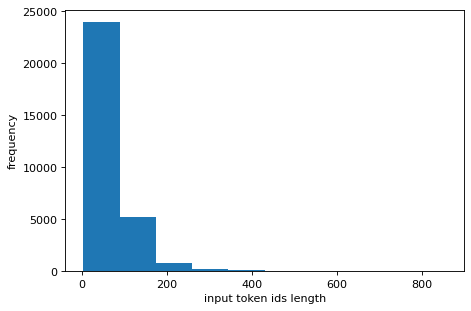

In [13]:
# This cell encodes all the entries in the dataset to plot the token lengths histogram of 
# i/p and o/p texts, and hence execution will be little bit time consuming.

# The maximun input and output token lengths of the model are task-specific.
# Given the dataset, analyze the required token lengths for fine-tuning.

model.encode_entries("input_text","/content/drive/MyDrive/Machine Learning/ip_tokens_len.jpg", "input token ids length")

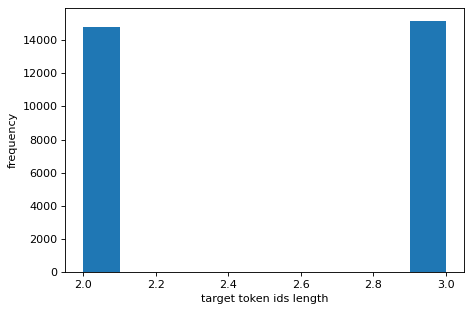

In [14]:
model.encode_entries("target_text","/content/drive/MyDrive/Machine Learning/op_tokens_len.jpg", "target token ids length")

In [15]:
model.initialize_seq_len(300,3)

In [16]:
# Testing the encode_str function

print(model.train_df['input_text'].iloc[0])
text = model.train_df['input_text'].iloc[0]
t1 = model.encode_str(text, model.tokenizer,model.max_inp_seq_len)
print(t1)
tokens = model.tokenizer.convert_ids_to_tokens(t1)
print(tokens)

ትክክል አላህ ሁሉኑም ቋንቋ ይሰማል እስልምናን ስላልተረዳክ ይሆናል እንጅ እስልምና ለሰው ልጅ አምራጭ የለለው ሀይማኖትና እና ከጎደሎ የፀዳ ነው ብህውሀት እና ኦሆዴድ ወይም በፖሎትካ ምቀየር ምጨመር አይኖርም እስከ አለም ፊፃመ ድሬስ ያው እንደነበር ይቀጥላልግን ቁርአን በአለም ባሉ ቋንቋዋች
tensor([   259,    986,   3434,  23166,  76448,   1973,    259,   5045,   3328,
          5565,   1116,    259,  15105,   1157,  15105, 141879, 169208,  72809,
         60268,  96468, 167920,   1305,   5359,  67023,   3434,   3303,   6779,
         68294,   9802,   9004,  72809,   1305,  46147,   7958,  21520,    259,
          1305,   9004,  54437,   3035,  11973,  76417,  10817,  32187,   2226,
          3866,   6575,  27386,   5361,   3306,  13367,   5244,   6304,   1237,
         32551,   4063,   4476,   4494,   1973,   1984,  29795,    986,   5361,
         61206,   6779,  13467,   2308,   5534,  25237,   1365,  16664,   6304,
           986,   2401,    259,   1116,   4207,   6572,   1557,    259,   1116,
         14515,  46294,  20933,   6575,  85468,  60803,  22729,   1116,    259,
          9997,

In [17]:
# Visualizing how the target texts are tokenized

uniq_lab = model.data['target_text'].unique()
for uni in uniq_lab:
  t1 = model.encode_str(uni,model.tokenizer,model.max_tar_seq_len)
  tokens = model.tokenizer.convert_ids_to_tokens(t1)
  print('Input ID: ',t1,', Tokens: ', tokens,', Decoded text: ',model.tokenizer.decode(t1))

Input ID:  tensor([1893,    1,    0]) , Tokens:  ['▁Free', '</s>', '<pad>'] , Decoded text:  Free</s><pad>
Input ID:  tensor([18982,   265,     1]) , Tokens:  ['▁Hat', 'e', '</s>'] , Decoded text:  Hate</s>


In [18]:
# Testing data generator

data_gen = model.data_generator(model.train_df, model.tokenizer, 8)
data_batch = next(data_gen)
#print('data_batch:',data_batch)
print('Input shape:', data_batch[0].shape)
print('Output shape:', data_batch[1].shape)

Input shape: torch.Size([8, 300])
Output shape: torch.Size([8, 3])


In [19]:
len(model.tokenizer.vocab)

250100

**Encode Inputs**

**Training**


In [20]:
n_epochs = 10
train_batch_size = 10
eval_batch_size = 5
lr = 5e-4 

In [21]:
model.set_training_parameters(n_epochs, train_batch_size, eval_batch_size, lr)

In [22]:
print('Total Training Steps(Batches) per Epoch: '+str(model.n_batches))
print('Printing & Validation Frequency: '+str(model.val_freq))
print('Checkpoint Saving Frequency: '+str(model.checkpoint_freq))

Total Training Steps(Batches) per Epoch: 2100
Printing & Validation Frequency: 75
Checkpoint Saving Frequency: 200


In [23]:
# Optimizer
optimizer = AdamW(model.model.parameters(), lr=lr)
# Create a schedule with a learning rate that decreases linearly from the initial lr set in the optimizer to 0, 
# after a warmup period during which it increases linearly from 0 to the initial lr set in the optimizer.
# Warmup is a way to reduce the primacy effect of the early training examples.
scheduler = get_linear_schedule_with_warmup(
    optimizer, model.n_warmup_steps, model.total_steps)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [24]:
model.fine_tune_model(optimizer,scheduler)

  0%|          | 0/2100 [00:00<?, ?it/s]

Epoch: 1 | Step: 75 | Avg. train loss: 5.677 | Avg. val loss: 0.238 | lr: 0.00017857142857142857
Epoch: 1 | Step: 150 | Avg. train loss: 0.297 | Avg. val loss: 0.253 | lr: 0.00035714285714285714
Epoch: 1 | Step: 225 | Avg. train loss: 0.663 | Avg. val loss: 0.354 | lr: 0.0004996392496392497
Epoch: 1 | Step: 300 | Avg. train loss: 0.266 | Avg. val loss: 0.236 | lr: 0.0004978354978354978
Epoch: 1 | Step: 375 | Avg. train loss: 0.246 | Avg. val loss: 0.234 | lr: 0.000496031746031746
Epoch: 1 | Step: 450 | Avg. train loss: 0.249 | Avg. val loss: 0.232 | lr: 0.0004942279942279943
Epoch: 1 | Step: 525 | Avg. train loss: 0.256 | Avg. val loss: 0.254 | lr: 0.0004924242424242425
Epoch: 1 | Step: 600 | Avg. train loss: 0.242 | Avg. val loss: 0.242 | lr: 0.0004906204906204906
Epoch: 1 | Step: 675 | Avg. train loss: 0.240 | Avg. val loss: 0.234 | lr: 0.0004888167388167388
Epoch: 1 | Step: 750 | Avg. train loss: 0.241 | Avg. val loss: 0.241 | lr: 0.000487012987012987
Epoch: 1 | Step: 825 | Avg. tra

  0%|          | 0/2100 [00:00<?, ?it/s]

Epoch: 2 | Step: 75 | Avg. train loss: 0.230 | Avg. val loss: 0.210 | lr: 0.0004527417027417027
Epoch: 2 | Step: 150 | Avg. train loss: 0.241 | Avg. val loss: 0.242 | lr: 0.00045093795093795094
Epoch: 2 | Step: 225 | Avg. train loss: 0.230 | Avg. val loss: 0.241 | lr: 0.0004491341991341991
Epoch: 2 | Step: 300 | Avg. train loss: 0.245 | Avg. val loss: 0.241 | lr: 0.0004473304473304474
Epoch: 2 | Step: 375 | Avg. train loss: 0.241 | Avg. val loss: 0.256 | lr: 0.00044552669552669555
Epoch: 2 | Step: 450 | Avg. train loss: 0.246 | Avg. val loss: 0.213 | lr: 0.0004437229437229438
Epoch: 2 | Step: 525 | Avg. train loss: 0.236 | Avg. val loss: 0.257 | lr: 0.00044191919191919195
Epoch: 2 | Step: 600 | Avg. train loss: 0.233 | Avg. val loss: 0.275 | lr: 0.0004401154401154401
Epoch: 2 | Step: 675 | Avg. train loss: 0.241 | Avg. val loss: 0.254 | lr: 0.00043831168831168834
Epoch: 2 | Step: 750 | Avg. train loss: 0.241 | Avg. val loss: 0.308 | lr: 0.0004365079365079365
Epoch: 2 | Step: 825 | Avg.

  0%|          | 0/2100 [00:00<?, ?it/s]

Epoch: 3 | Step: 75 | Avg. train loss: 0.233 | Avg. val loss: 0.229 | lr: 0.0004022366522366522
Epoch: 3 | Step: 150 | Avg. train loss: 0.230 | Avg. val loss: 0.229 | lr: 0.00040043290043290043
Epoch: 3 | Step: 225 | Avg. train loss: 0.231 | Avg. val loss: 0.219 | lr: 0.0003986291486291486
Epoch: 3 | Step: 300 | Avg. train loss: 0.227 | Avg. val loss: 0.230 | lr: 0.0003968253968253968
Epoch: 3 | Step: 375 | Avg. train loss: 0.232 | Avg. val loss: 0.214 | lr: 0.000395021645021645
Epoch: 3 | Step: 450 | Avg. train loss: 0.231 | Avg. val loss: 0.229 | lr: 0.00039321789321789327
Epoch: 3 | Step: 525 | Avg. train loss: 0.235 | Avg. val loss: 0.251 | lr: 0.00039141414141414144
Epoch: 3 | Step: 600 | Avg. train loss: 0.237 | Avg. val loss: 0.224 | lr: 0.00038961038961038966
Epoch: 3 | Step: 675 | Avg. train loss: 0.228 | Avg. val loss: 0.225 | lr: 0.00038780663780663783
Epoch: 3 | Step: 750 | Avg. train loss: 0.238 | Avg. val loss: 0.240 | lr: 0.000386002886002886
Epoch: 3 | Step: 825 | Avg. 

  0%|          | 0/2100 [00:00<?, ?it/s]

Epoch: 4 | Step: 75 | Avg. train loss: 0.223 | Avg. val loss: 0.237 | lr: 0.00035173160173160176
Epoch: 4 | Step: 150 | Avg. train loss: 0.227 | Avg. val loss: 0.260 | lr: 0.00034992784992784993
Epoch: 4 | Step: 225 | Avg. train loss: 0.224 | Avg. val loss: 0.254 | lr: 0.0003481240981240981
Epoch: 4 | Step: 300 | Avg. train loss: 0.231 | Avg. val loss: 0.225 | lr: 0.0003463203463203463
Epoch: 4 | Step: 375 | Avg. train loss: 0.233 | Avg. val loss: 0.239 | lr: 0.0003445165945165945
Epoch: 4 | Step: 450 | Avg. train loss: 0.228 | Avg. val loss: 0.237 | lr: 0.0003427128427128427
Epoch: 4 | Step: 525 | Avg. train loss: 0.226 | Avg. val loss: 0.222 | lr: 0.0003409090909090909
Epoch: 4 | Step: 600 | Avg. train loss: 0.225 | Avg. val loss: 0.258 | lr: 0.00033910533910533916
Epoch: 4 | Step: 675 | Avg. train loss: 0.228 | Avg. val loss: 0.241 | lr: 0.00033730158730158733
Epoch: 4 | Step: 750 | Avg. train loss: 0.245 | Avg. val loss: 0.257 | lr: 0.0003354978354978355
Epoch: 4 | Step: 825 | Avg.

  0%|          | 0/2100 [00:00<?, ?it/s]

Epoch: 5 | Step: 75 | Avg. train loss: 0.236 | Avg. val loss: 0.228 | lr: 0.00030122655122655125
Epoch: 5 | Step: 150 | Avg. train loss: 0.230 | Avg. val loss: 0.242 | lr: 0.0002994227994227994
Epoch: 5 | Step: 225 | Avg. train loss: 0.231 | Avg. val loss: 0.222 | lr: 0.00029761904761904765
Epoch: 5 | Step: 300 | Avg. train loss: 0.232 | Avg. val loss: 0.225 | lr: 0.0002958152958152958
Epoch: 5 | Step: 375 | Avg. train loss: 0.235 | Avg. val loss: 0.239 | lr: 0.000294011544011544
Epoch: 5 | Step: 450 | Avg. train loss: 0.230 | Avg. val loss: 0.229 | lr: 0.0002922077922077922
Epoch: 5 | Step: 525 | Avg. train loss: 0.231 | Avg. val loss: 0.220 | lr: 0.0002904040404040404
Epoch: 5 | Step: 600 | Avg. train loss: 0.234 | Avg. val loss: 0.224 | lr: 0.0002886002886002886
Epoch: 5 | Step: 675 | Avg. train loss: 0.232 | Avg. val loss: 0.229 | lr: 0.00028679653679653677
Epoch: 5 | Step: 750 | Avg. train loss: 0.227 | Avg. val loss: 0.222 | lr: 0.00028499278499278505
Epoch: 5 | Step: 825 | Avg. 

  0%|          | 0/2100 [00:00<?, ?it/s]

Epoch: 6 | Step: 75 | Avg. train loss: 0.228 | Avg. val loss: 0.231 | lr: 0.00025072150072150075
Epoch: 6 | Step: 150 | Avg. train loss: 0.226 | Avg. val loss: 0.218 | lr: 0.0002489177489177489
Epoch: 6 | Step: 225 | Avg. train loss: 0.224 | Avg. val loss: 0.236 | lr: 0.00024711399711399714
Epoch: 6 | Step: 300 | Avg. train loss: 0.227 | Avg. val loss: 0.240 | lr: 0.0002453102453102453
Epoch: 6 | Step: 375 | Avg. train loss: 0.230 | Avg. val loss: 0.229 | lr: 0.0002435064935064935
Epoch: 6 | Step: 450 | Avg. train loss: 0.220 | Avg. val loss: 0.267 | lr: 0.0002417027417027417
Epoch: 6 | Step: 525 | Avg. train loss: 0.226 | Avg. val loss: 0.226 | lr: 0.0002398989898989899
Epoch: 6 | Step: 600 | Avg. train loss: 0.224 | Avg. val loss: 0.258 | lr: 0.0002380952380952381
Epoch: 6 | Step: 675 | Avg. train loss: 0.225 | Avg. val loss: 0.251 | lr: 0.00023629148629148632
Epoch: 6 | Step: 750 | Avg. train loss: 0.223 | Avg. val loss: 0.233 | lr: 0.0002344877344877345
Epoch: 6 | Step: 825 | Avg. 

  0%|          | 0/2100 [00:00<?, ?it/s]

Epoch: 7 | Step: 75 | Avg. train loss: 0.221 | Avg. val loss: 0.295 | lr: 0.00020021645021645022
Epoch: 7 | Step: 150 | Avg. train loss: 0.220 | Avg. val loss: 0.186 | lr: 0.0001984126984126984
Epoch: 7 | Step: 225 | Avg. train loss: 0.223 | Avg. val loss: 0.206 | lr: 0.00019660894660894664
Epoch: 7 | Step: 300 | Avg. train loss: 0.222 | Avg. val loss: 0.225 | lr: 0.00019480519480519483
Epoch: 7 | Step: 375 | Avg. train loss: 0.225 | Avg. val loss: 0.221 | lr: 0.000193001443001443
Epoch: 7 | Step: 450 | Avg. train loss: 0.225 | Avg. val loss: 0.221 | lr: 0.0001911976911976912
Epoch: 7 | Step: 525 | Avg. train loss: 0.227 | Avg. val loss: 0.223 | lr: 0.0001893939393939394
Epoch: 7 | Step: 600 | Avg. train loss: 0.222 | Avg. val loss: 0.240 | lr: 0.0001875901875901876
Epoch: 7 | Step: 675 | Avg. train loss: 0.223 | Avg. val loss: 0.239 | lr: 0.00018578643578643579
Epoch: 7 | Step: 750 | Avg. train loss: 0.222 | Avg. val loss: 0.247 | lr: 0.00018398268398268398
Epoch: 7 | Step: 825 | Avg.

  0%|          | 0/2100 [00:00<?, ?it/s]

Epoch: 8 | Step: 75 | Avg. train loss: 0.219 | Avg. val loss: 0.227 | lr: 0.0001497113997113997
Epoch: 8 | Step: 150 | Avg. train loss: 0.212 | Avg. val loss: 0.222 | lr: 0.0001479076479076479
Epoch: 8 | Step: 225 | Avg. train loss: 0.212 | Avg. val loss: 0.205 | lr: 0.0001461038961038961
Epoch: 8 | Step: 300 | Avg. train loss: 0.217 | Avg. val loss: 0.232 | lr: 0.0001443001443001443
Epoch: 8 | Step: 375 | Avg. train loss: 0.216 | Avg. val loss: 0.225 | lr: 0.00014249639249639252
Epoch: 8 | Step: 450 | Avg. train loss: 0.221 | Avg. val loss: 0.239 | lr: 0.0001406926406926407
Epoch: 8 | Step: 525 | Avg. train loss: 0.215 | Avg. val loss: 0.197 | lr: 0.0001388888888888889
Epoch: 8 | Step: 600 | Avg. train loss: 0.215 | Avg. val loss: 0.217 | lr: 0.00013708513708513709
Epoch: 8 | Step: 675 | Avg. train loss: 0.218 | Avg. val loss: 0.216 | lr: 0.00013528138528138528
Epoch: 8 | Step: 750 | Avg. train loss: 0.219 | Avg. val loss: 0.214 | lr: 0.00013347763347763348
Epoch: 8 | Step: 825 | Avg.

  0%|          | 0/2100 [00:00<?, ?it/s]

Epoch: 9 | Step: 75 | Avg. train loss: 0.207 | Avg. val loss: 0.232 | lr: 9.92063492063492e-05
Epoch: 9 | Step: 150 | Avg. train loss: 0.201 | Avg. val loss: 0.231 | lr: 9.740259740259742e-05
Epoch: 9 | Step: 225 | Avg. train loss: 0.206 | Avg. val loss: 0.203 | lr: 9.55988455988456e-05
Epoch: 9 | Step: 300 | Avg. train loss: 0.209 | Avg. val loss: 0.181 | lr: 9.37950937950938e-05
Epoch: 9 | Step: 375 | Avg. train loss: 0.206 | Avg. val loss: 0.273 | lr: 9.199134199134199e-05
Epoch: 9 | Step: 450 | Avg. train loss: 0.208 | Avg. val loss: 0.215 | lr: 9.018759018759019e-05
Epoch: 9 | Step: 525 | Avg. train loss: 0.214 | Avg. val loss: 0.215 | lr: 8.838383838383838e-05
Epoch: 9 | Step: 600 | Avg. train loss: 0.210 | Avg. val loss: 0.215 | lr: 8.658008658008658e-05
Epoch: 9 | Step: 675 | Avg. train loss: 0.209 | Avg. val loss: 0.195 | lr: 8.477633477633479e-05
Epoch: 9 | Step: 750 | Avg. train loss: 0.210 | Avg. val loss: 0.251 | lr: 8.297258297258297e-05
Epoch: 9 | Step: 825 | Avg. train 

  0%|          | 0/2100 [00:00<?, ?it/s]

Epoch: 10 | Step: 75 | Avg. train loss: 0.194 | Avg. val loss: 0.251 | lr: 4.870129870129871e-05
Epoch: 10 | Step: 150 | Avg. train loss: 0.187 | Avg. val loss: 0.286 | lr: 4.68975468975469e-05
Epoch: 10 | Step: 225 | Avg. train loss: 0.192 | Avg. val loss: 0.237 | lr: 4.5093795093795094e-05
Epoch: 10 | Step: 300 | Avg. train loss: 0.183 | Avg. val loss: 0.209 | lr: 4.329004329004329e-05
Epoch: 10 | Step: 375 | Avg. train loss: 0.186 | Avg. val loss: 0.281 | lr: 4.1486291486291486e-05
Epoch: 10 | Step: 450 | Avg. train loss: 0.191 | Avg. val loss: 0.248 | lr: 3.968253968253968e-05
Epoch: 10 | Step: 525 | Avg. train loss: 0.189 | Avg. val loss: 0.232 | lr: 3.787878787878788e-05
Epoch: 10 | Step: 600 | Avg. train loss: 0.180 | Avg. val loss: 0.224 | lr: 3.6075036075036075e-05
Epoch: 10 | Step: 675 | Avg. train loss: 0.183 | Avg. val loss: 0.176 | lr: 3.427128427128427e-05
Epoch: 10 | Step: 750 | Avg. train loss: 0.183 | Avg. val loss: 0.194 | lr: 3.246753246753247e-05
Epoch: 10 | Step: 8

In [25]:
# save the training and validation loss values

if not os.path.exists('/content/drive/MyDrive/Machine Learning/Loss'):
  os.mkdir('/content/drive/MyDrive/Machine Learning/Loss')

pd.DataFrame(model.losses).to_csv("/content/drive/MyDrive/Machine Learning/Loss/train_loss.csv")
pd.DataFrame(model.val_losses).to_csv("/content/drive/MyDrive/Machine Learning/Loss/val_loss.csv")

In [26]:
# Load the loss values

train_loss_= pd.read_csv('/content/drive/MyDrive/Machine Learning/Loss/train_loss.csv', index_col=0)
val_loss_= pd.read_csv('/content/drive/MyDrive/Machine Learning/Loss/val_loss.csv', index_col=0)


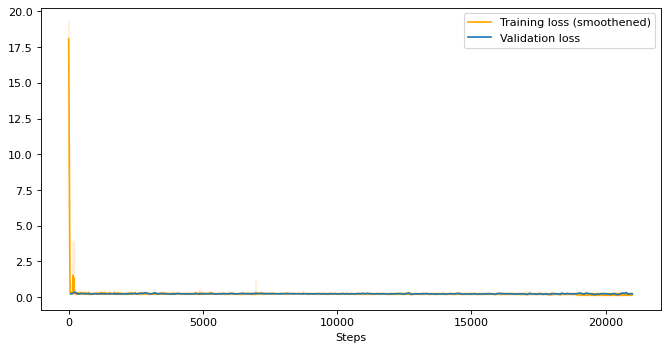

In [27]:
# visualizing the training and validation losses

# Actual training loss with low opacity
fig = plt.figure(figsize=(10, 5), dpi=80)
plt.plot(train_loss_, alpha=0.15, color='orange')

# smoothening the training loss
# window size is chosen depending upon the amount of smoothening required
window = 11
order = 1
y_ = savgol_filter(train_loss_['0'], window, order)
plt.plot(y_, color='orange', label='Training loss (smoothened)')

# Validation loss
val_loss_df = copy.deepcopy(val_loss_) 
val_loss_df.index = (val_loss_.index+1)*model.val_freq
plt.plot(val_loss_df, label='Validation loss')

plt.legend(loc="upper right")
plt.xlabel('Steps')

# save the plot if needed
fig.savefig('/content/drive/MyDrive/Machine Learning/Loss/Loss_Plot.png', dpi=fig.dpi)

**Model Testing**

In [28]:
# test the model on multiple batches to find average test accuracy.
# wrong predictions are saved to 'wrong_predictions.csv' file for further analysis.

Test_acc_values = []
wrong_pred = []
test_n_batches = 200
print('Model testing on test dataset: \n')
for _ in tqdm_notebook_(range(test_n_batches)):
  acc, wrong_pred = model.test_model(model.test_df, wrong_pred, max_iter=50)
  Test_acc_values.append(acc)


print('Avg. Test Accuracy: {:.4f}'.format(np.mean(Test_acc_values))) 
wrong_pred_df = pd.DataFrame (wrong_pred, columns = ['Input_text', 'True_target', 'Predicted'])
wrong_pred_df.to_csv("/content/drive/MyDrive/Machine Learning/wrong_predictions.csv")

Model testing on test dataset: 



  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1364: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


Avg. Test Accuracy: 0.5600


In [ ]:
# # function to test the model on 'max_iter' examples 

# def test_model(test_df, tokenizer, wrong_prediction, max_iter):

#   max_test_iters = max_iter
#   correct_predictions = 0

#   for _ in range(max_test_iters):
#     num = random.randint(0,len(test_df['input_text'])-1)
#     test = test_df.iloc[num]

#     input_ids = encode_str(text = test['input_text'], tokenizer = tokenizer, seq_len = 40)
#     input_ids = input_ids.unsqueeze(0).cuda()

#     #print('Truncated input text:', tokenizer.convert_tokens_to_string(
#     #  tokenizer.convert_ids_to_tokens(input_ids[0])))

#     output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=1, length_penalty = 1, no_repeat_ngram_size=2)
#     # print(output_tokens)
#     for token_set in output_tokens:
#       prediction = tokenizer.decode(token_set,skip_special_tokens=True)
#       if prediction == test['target_text']:
#         correct_predictions += 1
#       else:
#         wrong_prediction.append([test['input_text'], test['target_text'], prediction])

#   return correct_predictions/max_test_iters, wrong_prediction

In [ ]:
# test the model on multiple batches to find average test accuracy.
# wrong predictions are saved to 'wrong_predictions.csv' file for further analysis.

Test_acc_values = []
wrong_pred = []
test_n_batches = 200
print('Model testing on test dataset: \n')
for _ in tqdm_notebook_(range(test_n_batches)):
  acc, wrong_pred = test_model(test_df, tokenizer, wrong_pred, max_iter=50)
  Test_acc_values.append(acc)


print('Avg. Test Accuracy: {:.4f}'.format(np.mean(Test_acc_values))) 
wrong_pred_df = pd.DataFrame (wrong_pred, columns = ['Input_text', 'True_target', 'Predicted'])
wrong_pred_df.to_csv("/content/drive/MyDrive/Machine Learning/wrong_predictions.csv")


Model testing on test dataset: 



NameError: ignored

**Load the weights (post-training part)**

In [ ]:
# After fine-tuning, if we need to load the saved model checkpoint.
# If using different checkpoint saving frequency during training, then make sure to change the corresponding filename.

model_name=model.model_path+'Step-300_checkpoint_lang_pred.pt'
model.model.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [ ]:
test_model_name = "/content/drive/MyDrive/Machine Learning/fine-tuned_mt5/"+"Step-300_checkpoint_lang_pred.pt"

In [ ]:
test_model=MT5ForConditionalGeneration.from_pretrained("google/mt5-small")

In [ ]:
test_model.cuda()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("google/mt5-small")
    # self.model = model.cuda()

/usr/local/lib/python3.7/dist-packages/transformers/convert_slow_tokenizer.py:447: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"


In [ ]:
test_model.load_state_dict(torch.load("/content/drive/MyDrive/Machine Learning/fine-tuned_mt5/"+"Step-2252_checkpoint_lang_pred.pt"))

<All keys matched successfully>

In [ ]:
# function to encode a given string and return token ids

def encode_str(text, tokenizer, seq_len):  
  """ Tokenize, pad to max length and encode to ids 
      Returns tensor with token ids """
  input_ids = tokenizer.encode(
      text=text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return input_ids[0]

In [ ]:
    # num = random.randint(0,len(test_df['input_text'])-1)
    # test = test_df.iloc[num]
test="ዶ/ር አብይ ትምክህተኛ እና ነፍጠኛ ነው።"

input_ids = encode_str(text = test, tokenizer = tokenizer, seq_len = 40)
input_ids = input_ids.unsqueeze(0).cuda()

#print('Truncated input text:', tokenizer.convert_tokens_to_string(
#  tokenizer.convert_ids_to_tokens(input_ids[0])))

output_tokens = test_model.generate(input_ids, num_beams=10, num_return_sequences=1, length_penalty = 1, no_repeat_ngram_size=2)
# print(output_tokens)
for token_set in output_tokens:
  prediction = tokenizer.decode(token_set,skip_special_tokens=True)
  print(token_set, " : ", prediction)

tensor([    0, 18982,   265,     1], device='cuda:0')  :  Hate


In [ ]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.6 MB 3.8 MB/s 
     |████████████████████████████████| 84 kB 2.1 MB/s 
     |████████████████████████████████| 55 kB 2.3 MB/s 
     |████████████████████████████████| 272 kB 24.4 MB/s 
     |████████████████████████████████| 106 kB 70.2 MB/s 
     |████████████████████████████████| 54 kB 3.6 MB/s 
     |████████████████████████████████| 84 kB 4.1 MB/s 
     |████████████████████████████████| 2.3 MB 59.8 MB/s 
     |████████████████████████████████| 212 kB 56.2 MB/s 
     |████████████████████████████████| 56 kB 5.1 MB/s 
     |████████████████████████████████| 63 kB 2.5 MB/s 
     |████████████████████████████████| 80 kB 10.4 MB/s 
     |████████████████████████████████| 68 kB 7.0 MB/s 
     |████████████████████████████████| 46 kB 4.4 MB/s 
     |████████████████████████████████| 593 kB 74.8 MB/s 
     |████████████████████████████████| 4.0 MB 6

In [ ]:
import gradio as gr
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer


In [ ]:

nltk.download("vader_lexicon")
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
def sentiment_analysis(text):
    input_ids = model.encode_str(text = text, tokenizer = model.tokenizer, max_seq_len = 40)
    input_ids = input_ids.unsqueeze(0).cuda()
    output_tokens = model.model.generate(input_ids, num_beams=10, num_return_sequences=1, length_penalty = 1, no_repeat_ngram_size=2)

    for token_set in output_tokens:
      prediction = model.tokenizer.decode(token_set,skip_special_tokens=True)
      return prediction
    # scores = sid.polarity_scores(text)
    # del scores["compound"]
    # return scores
# test="ዶ/ር አብይ ትምክህተኛ እና ነፍጠኛ ነው።"



#print('Truncated input text:', tokenizer.convert_tokens_to_string(
#  tokenizer.convert_ids_to_tokens(input_ids[0])))

# print(output_tokens)
  # print(token_set, " : ", prediction)

In [ ]:
demo = gr.Interface(
    fn=sentiment_analysis, 
    inputs=gr.Textbox(placeholder="Enter a positive or negative sentence here..."), 
    outputs="text", 
    examples=[["አንተ ነፍጠኛ እና ትምክህተኛ ነህ!"]])

demo.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://82f24330b9f62ff8.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x7efa8d861e90>,
 'http://127.0.0.1:7861/',
 'https://82f24330b9f62ff8.gradio.app')